# 実測ビームの解析　等高線プロット

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'axes.facecolor': 'w'})
mpl.rcParams.update({'axes.edgecolor': 'k'})
mpl.rcParams.update({'figure.facecolor': 'w'})
mpl.rcParams.update({'figure.edgecolor': 'w'})
mpl.rcParams.update({'axes.grid': True})
mpl.rcParams.update({'grid.linestyle': ':'})
mpl.rcParams.update({'figure.figsize': [16, 6]})

In [2]:
def get_azel_ant30logdata(filename,linemargin=10,starting_keyword='cmd ='):

    ret = {}

    # file reading
    datalines = ''
    with open(filename)as f:
        datalines= f.readlines()
        pass

    # get center position
    x0 = float(datalines[np.where(['OffX1_HorD' in d for d in datalines])[0][0]].split('\t')[-1]) + \
         float(datalines[np.where(['OffX1_Min' in d for d in datalines])[0][0]].split('\t')[-1])/60 + \
         float(datalines[np.where(['OffX1_Sec' in d for d in datalines])[0][0]].split('\t')[-1])/3600
    y0 = float(datalines[np.where(['OffY1_Deg' in d for d in datalines])[0][0]].split('\t')[-1]) + \
         float(datalines[np.where(['OffY1_Min' in d for d in datalines])[0][0]].split('\t')[-1])/60 + \
         float(datalines[np.where(['OffY1_Sec' in d for d in datalines])[0][0]].split('\t')[-1])/3600
    
    # get target-line region
    tmp = np.where([starting_keyword in d for d in datalines])[0]
    lnbgn = tmp[0] - linemargin
    lnend = tmp[-1] + linemargin

    # Flag to skip lines
    skip = False
    skip_next_line = False
    
    # Process lines within the target region
    for line in datalines[lnbgn:lnend]:
        if 'obsAuto(); Antenna Moving to Off-Point ID=-1' in line:
            skip = True
            print(f"Skipping from line: {line.strip()}")
        elif 'Off-Point Integ end' in line:
            skip = False
            print(f"Resuming at line: {line.strip()}")
            continue
        if skip:
            continue

        if 'obsAuto(); Antenna Moving to On-Point ID=' in line:
            skip_next_line = True
            continue
        elif skip_next_line:
            skip_next_line = False
            continue
        
    # get azel lines
    dl_ri = np.array([l.replace('\n','').replace(',','').replace('[','').replace(']','').split(' ') for l in datalines[lnbgn:lnend] if 'cmd' in l])
    
    # convert line strings to azel or time
    dt = np.array([datetime.datetime.strptime(' '.join(x.split('-')[:2]),'%Y/%m/%d %H:%M:%S.%f') for x in dl_ri[:,0]])
    ts = np.array([x.timestamp() for x in dt])

    cmdaz = np.array([float(x) for x in dl_ri[:,3]])
    cmdel = np.array([float(x) for x in dl_ri[:,4]])

    acuaz = np.array([float(x) for x in dl_ri[:,8]])
    acuel = np.array([float(x) for x in dl_ri[:,9]])
    
    ret['cmd_az'] = cmdaz
    ret['cmd_el'] = cmdel
    ret['actual_az'] = acuaz
    ret['actual_el'] = acuel
    ret['date'] = dt
    ret['timestamp'] = ts
    ret['fn'] = '.'.join(filename.split('/')[-1].split('.')[:-1])
    ret['center'] = (x0,y0)

    # get process time info. for each position moving
    #dl_ri = np.array([l.replace('\n','').replace(',','').replace('[','').replace(']','').split(' ') for l in datalines if 'raster scan timing check' in l])
    #timedelay_dt = np.array([datetime.datetime.strptime(' '.join(x.split('-')[:2]),'%Y/%m/%d %H:%M:%S.%f') for x in dl_ri[:,0]])
    #timedelay = np.array([float(x) for x in dl_ri[:,6]])
    #ret['timedelay'] = timedelay
    #ret['timedelay_dt'] = timedelay_dt
    
    return ret

In [3]:
def get_spadata(filename):
    ret = {}

    spa_pd = pd.read_csv(filename, sep=',', header=None, names=['date','power','psd'])
    ret['date'] = np.array([datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in spa_pd.date])
    ret['timestamp'] = np.array([x.timestamp() for x in ret['date']])
    ret['power'] = 10**(np.array(spa_pd.power)/10)
    ret['psd'] = 10**(np.array(spa_pd.psd)/10)
    ret['fn'] = '.'.join(filename.split('/')[-1].split('.')[:-1])

    return ret

In [4]:
import scipy 
from scipy import stats

def make_binnedarray(tod_az,tod_el,tod_val,az_bins=None,el_bins=None,select=None,statistic='mean'):
    if az_bins is None:
        az_bins = np.linspace(np.min(tod_az),np.max(tod_az),51)
    if el_bins is None:
        el_bins = np.linspace(np.min(tod_el),np.max(tod_el),51)

    if select is not None and np.shape(select) != np.shape(tod_val):
        print(f"ERROR:: Inconsistent array shape btw select ({np.shape(select)}) and tod_val ({np.shape(tod_val)})")
        return None

    x = None
    y = None
    z = None
    if select is None:
        x = tod_az
        y = tod_el
        z = tod_val
    else:
        x = tod_az[select]
        y = tod_el[select]
        z = tod_val[select]
    ret = stats.binned_statistic_2d(x,y,values=z,statistic=statistic,bins=(az_bins,el_bins))

    return ret.statistic.T,az_bins,el_bins

In [5]:
def make_map(tod_az,tod_el,tod_val,az_bins=None,el_bins=None,select=None,fig=None,ax=None,title='',vmax=None,vmin=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    if ax is None:
        if fig is None:
            fig,ax = plt.subplots()
        else:
            ax = fig.axes[0]
    binned_data,_,_ = make_binnedarray(tod_az,tod_el,tod_val,az_bins,el_bins,select)
    im = ax.imshow(binned_data,origin='lower',cmap=mpl.cm.jet,#interpolation='none',
                   extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
                   vmax=vmax,vmin=vmin)
    ax.set_aspect(1)
    ax.set_xlabel('AZ [deg]')
    ax.set_ylabel('EL [deg]')
    ax.set_aspect('equal')
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im, cax=cax)
    return fig,ax

import lmfit
def fit_2dgaussian(x,y,z,cent=(None,None),sigma0=[0.2,0.2],theta0=0,userange=None):
    def f(x, y, amp, x0, y0, sigma_x, sigma_y, theta):
        theta = np.radians(theta)
        sigx2 = sigma_x**2; sigy2 = sigma_y**2
        a = np.cos(theta)**2/(2*sigx2) + np.sin(theta)**2/(2*sigy2)
        b = np.sin(theta)**2/(2*sigx2) + np.cos(theta)**2/(2*sigy2)
        c = np.sin(2*theta)/(4*sigx2) - np.sin(2*theta)/(4*sigy2)

        expo = -a*(x-x0)**2 - b*(y-y0)**2 - 2*c*(x-x0)*(y-y0)
        return amp*np.exp(expo)

    fmodel = lmfit.Model(f, independent_vars=('x','y'))
    if userange is None:
        userange = np.array([True]*len(x))

    s = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isnan(z)) & userange

    if not hasattr(sigma0, '__iter__'):
        sigma0 = [sigma0,sigma0]
        pass
    if cent[0] is None or cent[1] is None:
        cent_index = np.argmax(z)
    else:
        cent_index = np.argmin((x-cent[0])**2+(y-cent[1])**2)

    return fmodel.fit(z[s], x=x[s], y=y[s], weights=np.ones_like(x[s]),
                      amp=np.max(z[cent_index-10:cent_index+10]), x0=x[cent_index], y0=y[cent_index],
                      sigma_x=sigma0[0], sigma_y=sigma0[1], theta=theta0)

def get_xy_ellipticalaxis(d,theta,x0,y0,xmin,xmax,ymin,ymax,perpendic=False):
    a = np.tan(theta/180*np.pi)
    if np.abs(a)>1e-9: # line not parallel to x-axis
        if perpendic:
            a = -1/a
        b = y0 - x0 * a
        dx = np.abs(d*np.cos(np.arctan(a)))
        if np.abs((xmax-xmin)/dx)>1e10: # line almost parallel to y-axis
            dy = np.abs(d*np.sin(np.arctan(a)))
            y = np.arange(ymin+dy,ymax,dy)
            x = (y-b)/a
            ss = (xmin<x) & (x<xmax)
        else:
            x = np.arange(xmin+dx,xmax,dx)
            y = a*x + b
            ss = (ymin<y) & (y<ymax)
        pass
    else:
        if not perpendic:
            x = np.arange(xmin+d,xmax,d)
            y = np.array([y0]*len(x))
            ss = np.array([True]*len(x))
        else:
            y = np.arange(ymin+d,ymax,d)
            x = np.array([x0]*len(y))
            ss = np.array([True]*len(x))
    return x[ss], y[ss]


In [6]:
dict_azel = get_azel_ant30logdata(r"ant30-log\ant30-raster_1-20240620142900_2.log")
dict_spa  = get_spadata(r"spa-log\logspa-20240620_143106.txt")

In [7]:
# 2. synchronize az and el to spa data + removed timestamp-out-ranged  data

import scipy
from scipy import signal
from scipy import interpolate

f_az = scipy.interpolate.interp1d(dict_azel['timestamp'],dict_azel['actual_az'])
f_el = scipy.interpolate.interp1d(dict_azel['timestamp'],dict_azel['actual_el'])

ss = np.where((dict_azel['timestamp'][0]<dict_spa['timestamp']) & (dict_spa['timestamp']<dict_azel['timestamp'][-1]))

ret_az = f_az(dict_spa['timestamp'][ss])
ret_el = f_el(dict_spa['timestamp'][ss])
ret_data = dict_spa['power'][ss]

In [8]:
# 4. configuration of map (decide this parameter by seeing map processed below)

step_az = 0.045
step_el = 0.045

# data selection
sel = np.array([True]*len(ret_az))

sel &= ret_az<92
sel &= 89.5<ret_az
sel &= ret_el>0.55
sel &= ret_el<3.05

#sel[:20] = False # remove initial moving of telescope

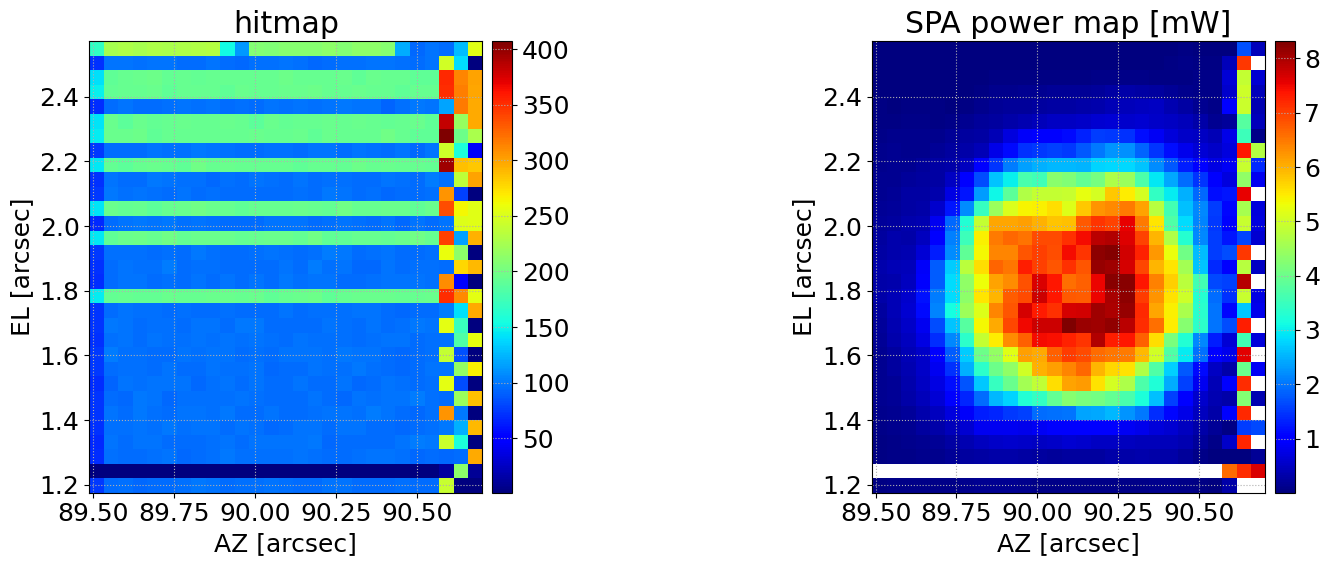

In [9]:
# 4. make map

from mpl_toolkits.axes_grid1 import make_axes_locatable
do_colorbar = True

d = np.max(ret_az[sel]) - np.min(ret_az[sel])
az_bins = np.arange(np.min(ret_az[sel])-0.01*d,np.max(ret_az[sel])+0.99*step_az,step_az)

d = np.max(ret_el[sel]) - np.min(ret_el[sel])
el_bins = np.arange(np.min(ret_el[sel])-0.01*d-step_el*0.5,np.max(ret_el[sel])+0.99*step_el,step_el)

fig,ax = plt.subplots(ncols=2)

z0,_,_ = make_binnedarray(ret_az[sel],ret_el[sel],ret_data[sel],az_bins=az_bins,el_bins=el_bins,statistic='count')
im0 = ax[0].imshow(z0,extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
                   vmax=None,vmin=1,
                   origin='lower',cmap=mpl.cm.jet,interpolation='none')

if do_colorbar:
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im0, cax=cax)

z1,_,_ = make_binnedarray(ret_az[sel],ret_el[sel],ret_data[sel],az_bins=az_bins,el_bins=el_bins)
z1dBm = np.log10(z1)*10
im1 = ax[1].imshow(z1,vmax=np.nanmax(z1),vmin=np.nanmin(z1),
               extent=(az_bins[0],az_bins[-1],el_bins[0],el_bins[-1]),
               origin='lower',cmap=mpl.cm.jet,interpolation='none')
if do_colorbar:
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=mpl.axes.Axes)
    fig.colorbar(im1, cax=cax)

for iax in ax:
    iax.set_aspect(1)
    iax.set_xlabel('AZ [arcsec]')
    iax.set_ylabel('EL [arcsec]')
    iax.set_aspect('equal')

ax[0].set_title('hitmap')
ax[1].set_title('SPA power map [mW]')
fig.tight_layout()


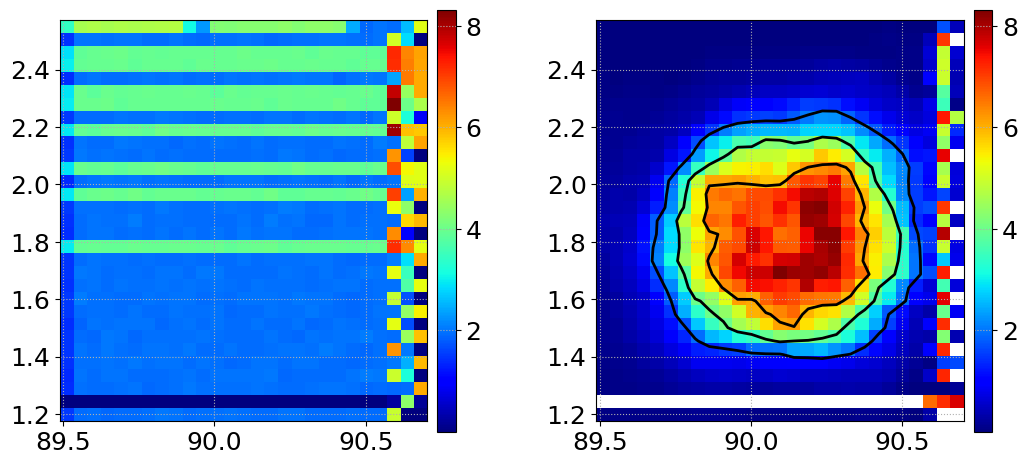

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

do_colorbar = True

d = np.max(ret_az[sel]) - np.min(ret_az[sel])
az_bins = np.arange(np.min(ret_az[sel])-0.01*d, np.max(ret_az[sel])+0.99*step_az, step_az)

d = np.max(ret_el[sel]) - np.min(ret_el[sel])
el_bins = np.arange(np.min(ret_el[sel])-0.01*d-step_el*0.5, np.max(ret_el[sel])+0.99*step_el, step_el)

fig, ax = plt.subplots(ncols=2, figsize=(11, 5))  # 正方形に近づける

# ヒットマップ
z0, _, _ = make_binnedarray(ret_az[sel], ret_el[sel], ret_data[sel], az_bins=az_bins, el_bins=el_bins, statistic='count')
im0 = ax[0].imshow(z0, extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]),
                   vmax=None, vmin=1, origin='lower', cmap='jet', interpolation='none', aspect='equal')

if do_colorbar:
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)  # カラーバーの高さを図と揃える
    fig.colorbar(im1, cax=cax)

# パワーマップ
z1, _, _ = make_binnedarray(ret_az[sel], ret_el[sel], ret_data[sel], az_bins=az_bins, el_bins=el_bins)
z1dBm = np.log10(z1) * 10
im1 = ax[1].imshow(z1, vmax=np.nanmax(z1), vmin=np.nanmin(z1),
               extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]),
               origin='lower', cmap='jet', interpolation='none', aspect='equal')
if do_colorbar:
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im1, cax=cax)

# **等高線適用範囲を設定 (89.5 ≤ AZ ≤ 90.5, 1.3 ≤ EL ≤ 2.4)**
mask_az = (az_bins[:-1] >= 89.5) & (az_bins[:-1] <= 90.55)
mask_el = (el_bins[:-1] >= 1.3) & (el_bins[:-1] <= 2.4)

# 2D のマスクを作成
mask_2d = np.outer(mask_el, mask_az)

# 適用範囲外を NaN にする
masked_z1 = np.where(mask_2d, z1, np.nan)

# **最大強度の25%, 50%, 75% の等高線**
max_intensity = np.nanmax(masked_z1)
threshold_25 = max_intensity * 0.25
threshold_50 = max_intensity * 0.5
threshold_75 = max_intensity * 0.75

# **等高線を描画（黒色）**
ax[1].contour(masked_z1, levels=[threshold_25, threshold_50, threshold_75], 
              colors='black', linewidths=2, extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]))

# 軸の調整
for iax in ax:
    iax.set_aspect(0.95)
    #iax.set_aspect('equal')

fig.tight_layout()
plt.show()


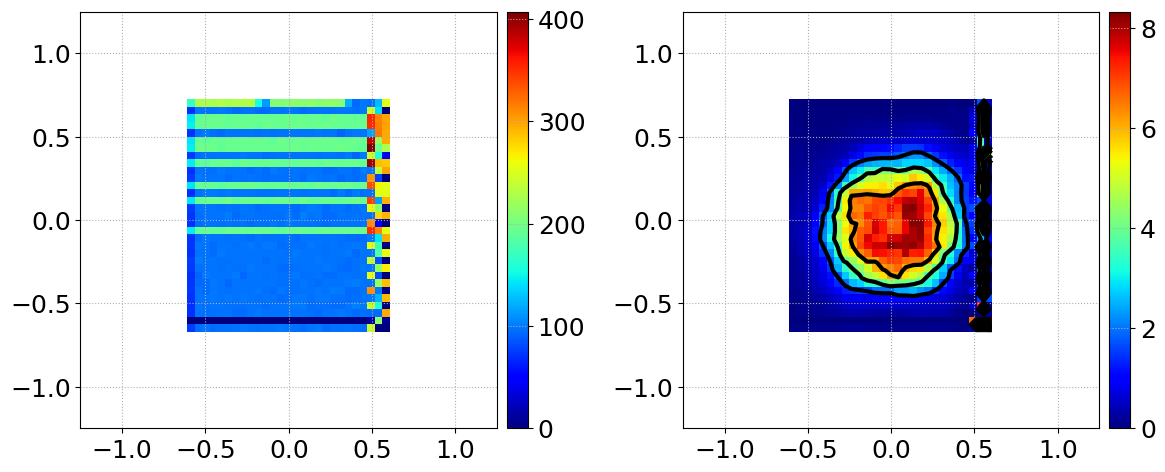

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

do_colorbar = True

# 原点を (88.5, 5.7) にシフト
az_shift = 90.1
el_shift = 1.85

# AZ, EL の範囲を調整（シフト後）
d = np.max(ret_az[sel] - az_shift) - np.min(ret_az[sel] - az_shift)
az_bins = np.arange(np.min(ret_az[sel] - az_shift) - 0.01 * d, 
                    np.max(ret_az[sel] - az_shift) + 0.99 * step_az, step_az)

d = np.max(ret_el[sel] - el_shift) - np.min(ret_el[sel] - el_shift)
el_bins = np.arange(np.min(ret_el[sel] - el_shift) - 0.01 * d - step_el * 0.5, 
                    np.max(ret_el[sel] - el_shift) + 0.99 * step_el, step_el)

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# **ヒットマップ**
z0, _, _ = make_binnedarray(ret_az[sel] - az_shift, ret_el[sel] - el_shift, ret_data[sel], 
                            az_bins=az_bins, el_bins=el_bins, statistic='count')

# NaNやinfを0に変換
z0 = np.nan_to_num(z0, nan=0, posinf=0, neginf=0)

im0 = ax[0].imshow(z0, extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]),
                   vmax=None, vmin=0, origin='lower', cmap='jet', interpolation='none')

if do_colorbar:
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im0, cax=cax)

# **パワーマップ**
z1, _, _ = make_binnedarray(ret_az[sel] - az_shift, ret_el[sel] - el_shift, ret_data[sel], 
                            az_bins=az_bins, el_bins=el_bins)

# NaNやinfを0に変換
z1 = np.nan_to_num(z1, nan=0, posinf=0, neginf=0)

z1dBm = np.log10(z1 + 1e-10) * 10  # log計算のために微小値を追加
im1 = ax[1].imshow(z1, vmax=np.nanmax(z1), vmin=0,
                   extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]),
                   origin='lower', cmap='jet', interpolation='none')

if do_colorbar:
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im1, cax=cax)

# **最大強度の50%の等高線を追加**
max_intensity = np.nanmax(z1)  # 最大強度を取得
threshold_25 = max_intensity * 0.25  # 25%閾値
threshold = max_intensity * 0.5  # 50%閾値
threshold_75 = max_intensity * 0.75  # 75%閾値

# 等高線を描画（黒色）
contour = ax[1].contour(z1, levels=[threshold_25], colors='black', linewidths=3, 
                         extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]))

contour = ax[1].contour(z1, levels=[threshold], colors='black', linewidths=3, 
                         extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]))

contour = ax[1].contour(z1, levels=[threshold_75], colors='black', linewidths=3, 
                         extent=(az_bins[0], az_bins[-1], el_bins[0], el_bins[-1]))

# 軸の調整
for iax in ax:
    iax.set_aspect('equal')

ax[0].set_xlim(-1.25, 1.25)
ax[0].set_ylim(-1.25, 1.25)
ax[1].set_xlim(-1.25, 1.25)
ax[1].set_ylim(-1.25, 1.25)

fig.tight_layout()
plt.show()
